## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [20]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1_l2


def build_mlp(input_shape,output_units=10,num_neurons=[512,256,128],drp_ratio=0.2,l1_ratio=0.0, l2_ratio=0.0):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i,n_units in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            
        else:
            x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units,activation="softmax",name="output")(x)
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    
    return model

In [21]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-4, 1e-8]
L2_EXP = [1e-4, 1e-8]

Dropout_EXP = [0.1, 0.4]
LAYER_NEURONS = [[128, 128, 128], [128, 256, 256], [128, 256, 512]]


In [24]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r,drp in itertools.product(L1_EXP, L2_EXP,Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f drp = %.6f" % (l1r, l2r, drp))
    
    model = build_mlp(input_shape=x_train.shape[1:],drp_ratio=drp,l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s-drp-%s" % (str(l1r), str(l2r), str(drp))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.000100, L2 = 0.000100 drp = 0.100000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________

50000/50000 [==============================] - 22s 432us/step - loss: 5.4292 - accuracy: 0.3922 - val_loss: 5.3331 - val_accuracy: 0.4134
Epoch 6/10
50000/50000 [==============================] - 21s 424us/step - loss: 5.3324 - accuracy: 0.4021 - val_loss: 5.2399 - val_accuracy: 0.4293
Epoch 7/10
50000/50000 [==============================] - 21s 429us/step - loss: 5.2379 - accuracy: 0.4138 - val_loss: 5.1625 - val_accuracy: 0.4332
Epoch 8/10
50000/50000 [==============================] - 21s 429us/step - loss: 5.1480 - accuracy: 0.4256 - val_loss: 5.0582 - val_accuracy: 0.4456
Epoch 9/10
50000/50000 [==============================] - 21s 418us/step - loss: 5.0619 - accuracy: 0.4356 - val_loss: 4.9876 - val_accuracy: 0.4499
Epoch 10/10
50000/50000 [==============================] - 21s 429us/step - loss: 4.9787 - accuracy: 0.4430 - val_loss: 4.9000 - val_accuracy: 0.4612
Experiment with L1 = 0.000100, L2 = 0.000000 drp = 0.400000
Model: "model_1"
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 418us/step - loss: 2.4045 - accuracy: 0.1516 - val_loss: 2.2367 - val_accuracy: 0.2522
Epoch 2/10
50000/50000 [==============================] - 20s 402us/step - loss: 2.2345 - accuracy: 0.2210 - val_loss: 2.0990 - val_accuracy: 0.3120
Epoch 3/10
50000/50000 [==============================] - 20s 404us/step - loss: 2.1504 - accuracy: 0.2561 - val_loss: 2.0318 - val_accuracy: 0.3381
Epoch 4/10
50000/50000 [==============================] - 20s 396us/step - loss: 2.0944 - accuracy: 0.2805 - val_loss: 1.9731 - val_accuracy: 0.3530
Epoch 5/10
50000/50000 [==============================] - 21s 412us/step - loss: 2.0566 - accuracy: 0.2964 - val_loss: 1.9345 - val_accuracy: 0.3679
Epoch 6/10
50000/50000 [==============================] - 20s 403us/step - loss: 2.0234 - accuracy: 0.3094 - val_loss: 1.9036 - val_accuracy: 0.3830
Epoch 7/10
50000/50000 [==============================] 

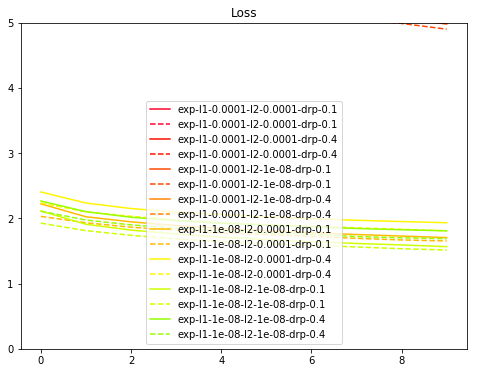

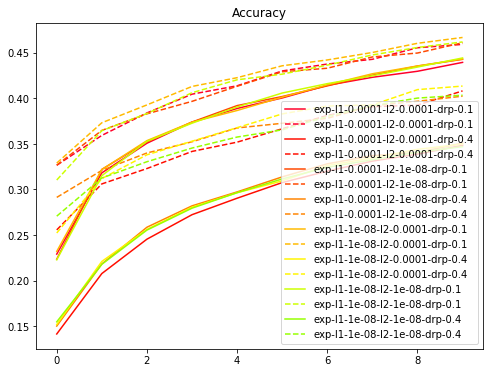

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
